# CNN
- Input data normalization was the key!
```Python
mean = df_window.mean(axis=(0, 1))
std = df_window.std(axis=(0, 1))
df_window_norm = (df_window - mean) / std
```
- Removed load, speed features since the model performance did not improve with it.

In [11]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import mlflow
import json
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader, random_split
# local
from analytics.gear_vibration.data_loader import load_data
from analytics.gear_vibration.visualization import confusion_matrix_nn
from analytics.utils import log_metrics_mlflow
from analytics.gear_vibration.models import CnnClassifier
from analytics.gear_vibration.model_trainer import ModelTrainer
from analytics.gear_vibration.data_loader import GearVibrationDataset
from analytics.gear_vibration.analysis import sliding_window

In [12]:
data, df = load_data(path=Path('./data/gear_vibration'))

In [13]:
VERSION = '0.0.1'
CONFIG = {'window_size': 256, 'step_size': 128, 'normalized': True, 'batch_size': 128}
mlflow_expiriment = 'gear_vibration'
model_name = f'{mlflow_expiriment}_cnn_w_{CONFIG["window_size"]}'

In [14]:
df_window, df_labels = sliding_window(df=df, window_size=CONFIG['window_size'], step_size=CONFIG['step_size'], features=['sensor1', 'sensor2'])
labels, fault_code = pd.factorize(df_labels['fault'])
mean = df_window.mean(axis=(0, 1))
std = df_window.std(axis=(0, 1))
df_window_norm = (df_window - mean) / std

In [15]:
dataset = GearVibrationDataset(features=df_window_norm, labels=labels)
model = CnnClassifier(in_channels=df_window_norm.shape[2], out_features=len(fault_code), input_length=df_window_norm.shape[1]) # yapf: disable
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
train, validate = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size=CONFIG['batch_size'], shuffle=False)
validate_loader = DataLoader(validate, batch_size=CONFIG['batch_size'], shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
num_epochs = 200
scheduler = StepLR(optimizer, step_size=30, gamma=0.3)
summary(
  model.to(device),
  input_size=(CONFIG['batch_size'], df_window_norm.shape[2], df_window_norm.shape[1])  # (batch, in_channels, seq_len)
)

Using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
CnnClassifier                            [128, 6]                  --
├─Sequential: 1-1                        [128, 256, 1]             --
│    └─Conv1d: 2-1                       [128, 64, 256]            704
│    └─BatchNorm1d: 2-2                  [128, 64, 256]            128
│    └─ReLU: 2-3                         [128, 64, 256]            --
│    └─MaxPool1d: 2-4                    [128, 64, 128]            --
│    └─Dropout: 2-5                      [128, 64, 128]            --
│    └─Conv1d: 2-6                       [128, 128, 128]           24,704
│    └─BatchNorm1d: 2-7                  [128, 128, 128]           256
│    └─ReLU: 2-8                         [128, 128, 128]           --
│    └─MaxPool1d: 2-9                    [128, 128, 64]            --
│    └─Dropout: 2-10                     [128, 128, 64]            --
│    └─Conv1d: 2-11                      [128, 256, 64]            98,560
│   

In [16]:
trainer = ModelTrainer(
  model=model,
  model_name=model_name,
  criterion=criterion,
  optimizer=optimizer,
  train_loader=train_loader,
  val_loader=validate_loader,
  num_epochs=num_epochs,
  device=device,
  scheduler=scheduler,
  version=VERSION,
  config=CONFIG,
  mlflow_expiriment=mlflow_expiriment,
  mlflow_url='http://localhost:5000',
)
label = {idx: fault[0] for idx, fault in enumerate(fault_code)}
tags = {'analysis': mlflow_expiriment, 'labels': json.dumps(label)} 

In [17]:
trainer.train(tags=tags)

Epoch [1/200], Training Loss: 1.1427, Validation Loss: 0.6692, Training Accuracy: 50.21%, Validation Accuracy: 72.29%
Epoch [2/200], Training Loss: 0.5137, Validation Loss: 0.2838, Training Accuracy: 78.65%, Validation Accuracy: 91.31%
Epoch [3/200], Training Loss: 0.3468, Validation Loss: 0.2487, Training Accuracy: 86.09%, Validation Accuracy: 91.24%
Epoch [4/200], Training Loss: 0.2686, Validation Loss: 0.1667, Training Accuracy: 89.71%, Validation Accuracy: 95.01%
Epoch [5/200], Training Loss: 0.2143, Validation Loss: 0.2016, Training Accuracy: 91.49%, Validation Accuracy: 93.59%
Epoch [6/200], Training Loss: 0.1820, Validation Loss: 0.1254, Training Accuracy: 93.34%, Validation Accuracy: 95.94%
Epoch [7/200], Training Loss: 0.1762, Validation Loss: 0.1074, Training Accuracy: 93.20%, Validation Accuracy: 96.51%
Epoch [8/200], Training Loss: 0.1589, Validation Loss: 0.0944, Training Accuracy: 94.43%, Validation Accuracy: 96.79%
Epoch [9/200], Training Loss: 0.1527, Validation Loss: 0

2025/05/29 16:02:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [97/200], Training Loss: 0.0391, Validation Loss: 0.0296, Training Accuracy: 98.91%, Validation Accuracy: 99.00%
Early stopping at epoch 97


2025/05/29 16:02:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Successfully registered model 'gear_vibration_cnn_w_256'.
2025/05/29 16:02:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gear_vibration_cnn_w_256, version 1


🏃 View run gear_vibration_cnn_w_256 at: http://localhost:5000/#/experiments/3/runs/d4ee2f0dfb704cdc8b0e5f07003bab59
🧪 View experiment at: http://localhost:5000/#/experiments/3


Created version '1' of model 'gear_vibration_cnn_w_256'.


CnnClassifier(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.2, inplace=False)
    (14): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): ReLU()
    (16): AdaptiveAvgPool1d(output_size=1)
  )
  (class

🏃 View run gear_vibration_cnn_w_256 at: http://localhost:5000/#/experiments/3/runs/d4ee2f0dfb704cdc8b0e5f07003bab59
🧪 View experiment at: http://localhost:5000/#/experiments/3
accuracy: 0.9900
precision_macro: 0.9902
recall_macro: 0.9903
f1_macro: 0.9901
precision_weighted: 0.9904
recall_weighted: 0.9900
f1_weighted: 0.9901


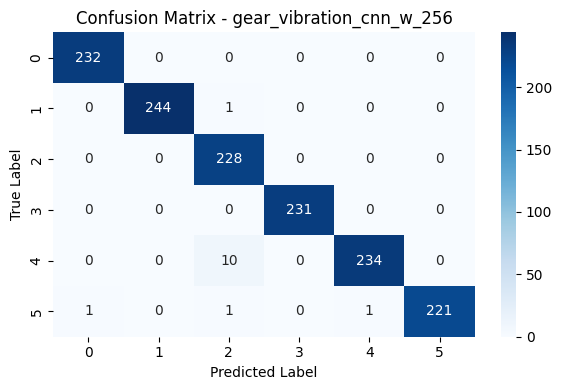

In [18]:
model.eval()
all_preds = []
all_labels = []
for X_batch, y_batch in validate_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    model = model.to(device)
    outputs = model(X_batch)
    preds = torch.argmax(outputs, dim=1)
    all_preds.append(preds.cpu().numpy())
    all_labels.append(y_batch.cpu().numpy())
y_pred = np.concatenate(all_preds)
y_test = np.concatenate(all_labels)
metrics = log_metrics_mlflow(y_test, y_pred, model_name=model_name, run_id=trainer.get_tmp_run_id())
for k, v in metrics.items():
    print(f'{k}: {v:.4f}')
